In [27]:
# Load json data
import json

class JointData:
    def __init__(self, joint_name, parent_joint_name, position, rotation):
        self.joint_name = joint_name
        self.parent_joint_name = parent_joint_name
        self.position = position  # [x, y, z]
        self.rotation = rotation  # [x, y, z, w] (Quaternion)
    
    def print_joint(self):
        print(f"name:{self.joint_name}")
        print(f"parent_joint_name:{self.parent_joint_name}")
        print(f"position:{self.position}")
        print(f"rotation:{self.rotation}")

class HandData:
    def __init__(self):
        self.joints = []

    def add_joint(self, joint: JointData):
        self.joints.append(joint)

def load_hand_data_from_json(file_path: str) -> HandData:
    """Load HandData from a JSON file with nested position and rotation fields."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    hand_data = HandData()
    for joint in data['joints']:
        # Parse position and rotation from nested structures
        position = [
            float(joint['position']['x']),
            float(joint['position']['y']),
            float(joint['position']['z']),
        ]
        rotation = [
            float(joint['rotation']['x']),
            float(joint['rotation']['y']),
            float(joint['rotation']['z']),
            float(joint['rotation']['w']),
        ]

        joint_data = JointData(
            joint_name=joint['jointName'],
            parent_joint_name=joint['parentJointName'],
            position=position,
            rotation=rotation
        )
        hand_data.add_joint(joint_data)
    return hand_data


In [28]:
# File path
standard_pose_file = "standard_gesture_female.json"  # Standard Gesture JSON File Path
test_pose_file = "oculus2/723lyz/gripdata_stage1_frame_1.json"         # Test Gesture JSON File Path

# Load JSON data
std_hand_data = load_hand_data_from_json(standard_pose_file)
test_hand_data = load_hand_data_from_json(test_pose_file)

for j in std_hand_data.joints:
    j.print_joint()

name:Hand_Start
parent_joint_name:Invalid
position:[0.0, 0.0, 0.0]
rotation:[0.0, 1.0, 0.0, 0.0]
name:Hand_WristRoot
parent_joint_name:Hand_WristRoot
position:[0.0, 0.0, 0.0]
rotation:[0.0, 0.0, 0.0, 1.0]
name:Hand_Thumb0
parent_joint_name:Hand_WristRoot
position:[0.020068995654582977, -0.011553998105227947, 0.010496998205780983]
rotation:[0.4286441504955292, -0.36502695083618164, -0.09970282763242722, 0.8204138875007629]
name:Hand_Thumb1
parent_joint_name:Hand_Thumb0
position:[0.02485242672264576, -4.637986421585083e-07, -3.2316893339157104e-07]
rotation:[0.30565375089645386, -0.07363971322774887, -0.1445111632347107, 0.9382267594337463]
name:Hand_Thumb2
parent_joint_name:Hand_Thumb1
position:[0.03251289948821068, -6.51925802230835e-09, -4.423782229423523e-09]
rotation:[-0.08124404400587082, 0.04789318889379501, -0.24259524047374725, 0.965532660484314]
name:Hand_Thumb3
parent_joint_name:Hand_Thumb2
position:[0.03379308432340622, -7.450580596923828e-09, 0.0]
rotation:[0.080798298120498

In [29]:
# Calculate the angular difference of quaternions
import math
from typing import List

def quaternion_dot(q1: List[float], q2: List[float]) -> float:
    """Calculate the dot product of two quaternions."""
    return sum(a * b for a, b in zip(q1, q2))

def quaternion_angle_difference(q1: List[float], q2: List[float]) -> float:
    """
    Calculate the angular difference (in degrees) between two quaternions.
    """
    dot = quaternion_dot(q1, q2)
    dot = max(min(dot, 1.0), -1.0)  # Clamp dot product to [-1, 1] to avoid numerical issues
    angle_rad = math.acos(abs(dot)) * 2  # Multiply by 2 for quaternion rotation
    angle_deg = math.degrees(angle_rad)
    return angle_deg

In [30]:
# Ignore joints that don't need to be compared
def should_ignore_joint(joint_name: str) -> bool:
    """
    Check if a joint should be ignored based on its name.
    """
    return joint_name.endswith("Root") or joint_name.endswith("Start") or joint_name.endswith("Tip")

In [31]:
# Compare gesture data, compare rotational differences in joints, and print matches
def compare_joint_rotation(std_joint: JointData, test_joint: JointData, rotation_threshold: float) -> bool:
    """
    Compare the rotation of two joints. Return True if they match, False otherwise.
    """
    angle_difference = quaternion_angle_difference(std_joint.rotation, test_joint.rotation)
    if angle_difference < rotation_threshold:
        print(f"Joint {std_joint.joint_name} matched.")
        return True
    else:
        print(f"Joint {std_joint.joint_name} mismatched! Angle difference: {angle_difference:.2f}°")
        return False


In [32]:
# The main function compares all the joints one by one
def compare_hand_pose(std_hand_data: HandData, test_hand_data: HandData, rotation_threshold: float = 15.0):
    """
    Compare a hand pose (test_hand_data) against a standard pose (std_hand_data).
    Print mismatched joints and return whether all joints match.
    """
    if len(std_hand_data.joints) != len(test_hand_data.joints):
        print("Joint count mismatch. Standard and test data do not have the same number of joints.")
        return False

    bone_matched = True

    for std_joint, test_joint in zip(std_hand_data.joints, test_hand_data.joints):
        # Ignore certain joints by name
        if should_ignore_joint(std_joint.joint_name):
            continue

        # Compare joint rotation
        if not compare_joint_rotation(std_joint, test_joint, rotation_threshold):
            bone_matched = False

    if bone_matched:
        print("All joints matched!")
    else:
        print("Some joints did not match.")
    
    return bone_matched

In [33]:
def analyze_all_users(root_folder: str, standard_pose_file: str, rotation_threshold=15.0):
    """
    Analyze all user folders in a root directory. Each user's folder contains JSON files for analysis.
    """
    # Get list of user folders
    user_folders = [os.path.join(root_folder, user) for user in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, user))]

    # Dictionary to store results for all users
    all_results = {}

    for user_folder in user_folders:
        user_id = os.path.basename(user_folder)  # Extract user ID from folder name
        print(f"\nAnalyzing user: {user_id}")

        # Analyze the user's data
        stage1_similarities, stage2_similarities = compute_similarities_with_visualization_separate(
            user_folder, standard_pose_file, rotation_threshold
        )

        # Store results in the dictionary
        all_results[user_id] = {
            "stage1": stage1_similarities,
            "stage2": stage2_similarities,
        }

    return all_results


In [34]:
# compare_hand_pose(std_hand_data, test_hand_data)

In [35]:
# Calculate similarity by number of joint matches
def calculate_similarity(std_hand_data: HandData, test_hand_data: HandData, rotation_threshold: float = 15.0):
    """
    Calculate the similarity between two hand poses based on joint matches.
    
    Similarity is defined as the percentage of joints that match within the given rotation threshold.
    """
    if len(std_hand_data.joints) != len(test_hand_data.joints):
        print("Joint count mismatch. Cannot calculate similarity.")
        return 0.0

    total_joints = len(std_hand_data.joints)
    matched_joints = 0

    for std_joint, test_joint in zip(std_hand_data.joints, test_hand_data.joints):
        # Ignore certain joints by name
        if should_ignore_joint(std_joint.joint_name):
            total_joints -= 1  # Exclude ignored joints from the total count
            continue

        # Compare joint rotation
        angle_difference = quaternion_angle_difference(std_joint.rotation, test_joint.rotation)
        if angle_difference < rotation_threshold:
            matched_joints += 1

    # Calculate similarity as a percentage
    similarity = (matched_joints / total_joints) * 100 if total_joints > 0 else 0.0
    return similarity


In [36]:
# similarity = calculate_similarity(std_hand_data, test_hand_data, rotation_threshold=15.0)
# print(f"Similarity: {similarity:.2f}%")

In [37]:
import os
import csv
import matplotlib.pyplot as plt

def get_stage_files(folder_path: str):
    """
    Retrieve and separate JSON files into stage1 and stage2 based on file name patterns.
    """
    stage1_files = []
    stage2_files = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json"):  # Only consider JSON files
            if "stage1" in file_name.lower():
                stage1_files.append(os.path.join(folder_path, file_name))
            elif "stage2" in file_name.lower():
                stage2_files.append(os.path.join(folder_path, file_name))

    # Sort files to ensure time-order visualization
    stage1_files.sort()
    stage2_files.sort()

    return stage1_files, stage2_files

def process_stage_files(stage_files, standard_pose_file, rotation_threshold=15.0):
    """
    Process a list of files for a specific stage and calculate similarities.
    """
    std_hand_data = load_hand_data_from_json(standard_pose_file)
    similarities = []

    for file_path in stage_files:
        test_hand_data = load_hand_data_from_json(file_path)
        similarity = calculate_similarity(std_hand_data, test_hand_data, rotation_threshold)
        similarities.append(similarity)
    
    return similarities

def save_results_to_csv(results, output_file):
    """
    Save similarity results to a CSV file.
    """
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["File Path", "Similarity"])
        for file_path, similarity in results:
            writer.writerow([file_path, similarity])

def plot_similarity(stage_similarities, stage_label):
    """
    Plot similarity trends for a specific stage.
    """
    # Create x-axis values as time steps (1, 2, 3, ...)
    time = list(range(1, len(stage_similarities) + 1))

    # Plot the stage
    plt.figure(figsize=(10, 6))
    plt.plot(time, stage_similarities, label=f"{stage_label}", marker='o', linestyle='-', linewidth=2)

    # Add labels, title, and legend
    plt.xlabel("Time (File Order)", fontsize=12)
    plt.ylabel("Similarity (%)", fontsize=12)
    plt.title(f"Similarity Trends for {stage_label}", fontsize=14)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

def compute_similarities_with_visualization_separate(folder_path: str, standard_pose_file: str, rotation_threshold=15.0):
    """
    Main process to compute similarities for stage1 and stage2 files, and visualize results separately.
    """
    # Separate files into stage1 and stage2
    stage1_files, stage2_files = get_stage_files(folder_path)

    print(f"Found {len(stage1_files)} files in stage1.")
    print(f"Found {len(stage2_files)} files in stage2.")

    # Process stage1 files
    print("\nProcessing stage1 files...")
    stage1_similarities = process_stage_files(stage1_files, standard_pose_file, rotation_threshold)

    # Process stage2 files
    print("\nProcessing stage2 files...")
    stage2_similarities = process_stage_files(stage2_files, standard_pose_file, rotation_threshold)

    # Visualize results separately
    print("\nVisualizing similarity trends for stage1...")
    plot_similarity(stage1_similarities, "Stage 1")

    print("\nVisualizing similarity trends for stage2...")
    plot_similarity(stage2_similarities, "Stage 2")

    # Save results to CSV
    save_results_to_csv(zip(stage1_files, stage1_similarities), "stage1_results.csv")
    save_results_to_csv(zip(stage2_files, stage2_similarities), "stage2_results.csv")

    print("\nResults saved to 'stage1_results.csv' and 'stage2_results.csv'.")

    return stage1_similarities, stage2_similarities


In [49]:
# Drawing someone's
def plot_similarity_filtered(stage1_similarities, stage2_similarities):
    """
    Plot similarity trends for stage1 and stage2 after filtering out similarities <= 50%.
    """
    # Filter out similarities <= 50%
    stage1_filtered = [sim for sim in stage1_similarities if sim > 50]
    stage2_filtered = [sim for sim in stage2_similarities if sim > 50]

    # Create x-axis values as time steps for filtered data
    stage1_time = list(range(1, len(stage1_filtered) + 1))
    stage2_time = list(range(1, len(stage2_filtered) + 1))

    # Plot stage1
    plt.figure(figsize=(10, 6))
    plt.plot(stage1_time, stage1_filtered, label="Stage 1 (Filtered)", marker='o', linestyle='-', linewidth=2, color='blue')

    # Plot stage2
    plt.plot(stage2_time, stage2_filtered, label="Stage 2 (Filtered)", marker='s', linestyle='--', linewidth=2, color='orange')

    # Add labels, title, and legend
    plt.xlabel("Time (File Order, Filtered)", fontsize=12)
    plt.ylabel("Similarity (%)", fontsize=12)
    plt.title("10086_Filtered Similarity Trends over Time", fontsize=14)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

def compute_similarities_with_visualization_filtered(folder_path: str, standard_pose_file: str, rotation_threshold=15.0):
    """
    Main process to compute similarities for stage1 and stage2 files, filter out similarities <= 50%,
    and visualize results.
    """
    # Separate files into stage1 and stage2
    stage1_files, stage2_files = get_stage_files(folder_path)

    print(f"Found {len(stage1_files)} files in stage1.")
    print(f"Found {len(stage2_files)} files in stage2.")

    # Process stage1 files
    print("\nProcessing stage1 files...")
    stage1_similarities = process_stage_files(stage1_files, standard_pose_file, rotation_threshold)

    # Process stage2 files
    print("\nProcessing stage2 files...")
    stage2_similarities = process_stage_files(stage2_files, standard_pose_file, rotation_threshold)

    # Filtered visualization
    print("\nVisualizing filtered similarity trends...")
    plot_similarity_filtered(stage1_similarities, stage2_similarities)

    # Save results to CSV
    save_results_to_csv(zip(stage1_files, stage1_similarities), "stage1_results.csv")
    save_results_to_csv(zip(stage2_files, stage2_similarities), "stage2_results.csv")

    print("\nResults saved to 'stage1_results.csv' and 'stage2_results.csv'.")

    return stage1_similarities, stage2_similarities


Found 2520 files in stage1.
Found 1814 files in stage2.

Processing stage1 files...

Processing stage2 files...

Visualizing filtered similarity trends...


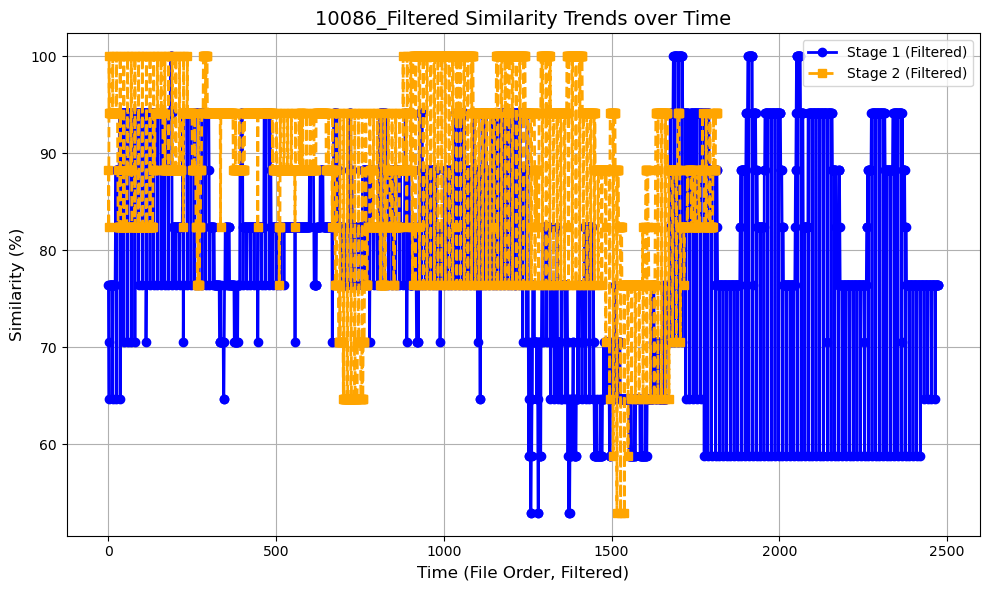


Results saved to 'stage1_results.csv' and 'stage2_results.csv'.


In [50]:
# Folder paths and standard pose files
# folder_path = "user_test_oculus3/user_test_oculus3/files/196"
folder_path = "oculus2/10086yly"
standard_pose_file = "standard_gesture_female.json"

# Calculate similarity and visualize
stage1_similarities, stage2_similarities = compute_similarities_with_visualization_filtered(folder_path, standard_pose_file, rotation_threshold=15.0)


In [ ]:
# Home folder path
root_folder = "oculus2"
standard_pose_file = "standard_gesture_female.json"

# Multi-user analysis functions
results = analyze_all_users(root_folder, standard_pose_file, rotation_threshold=15.0)


Analyzing user: 104
Found 3463 files in stage1.
Found 1439 files in stage2.

Processing stage1 files...

Processing stage2 files...

Visualizing similarity trends for stage1...


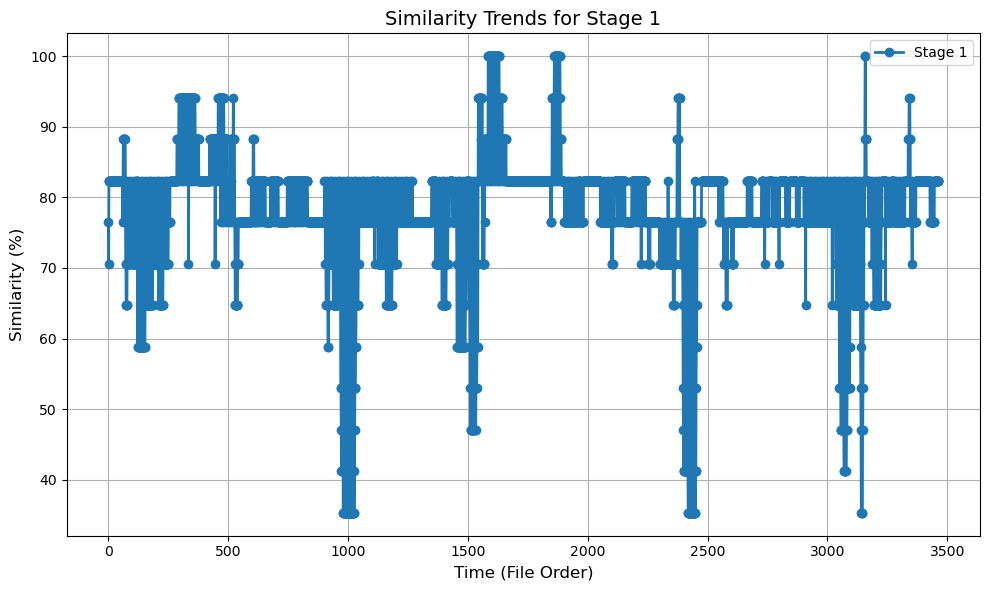


Visualizing similarity trends for stage2...


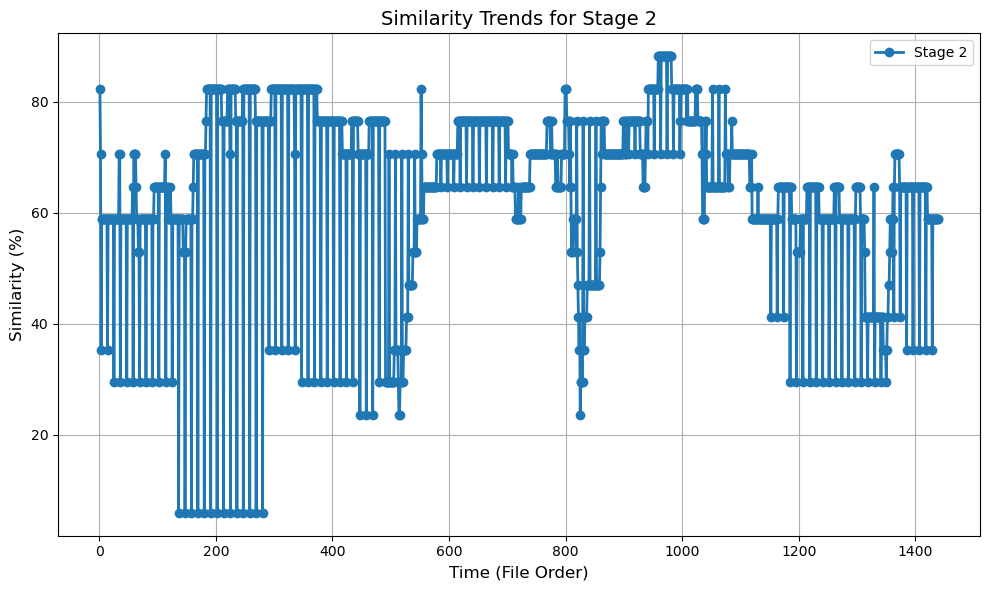


Results saved to 'stage1_results.csv' and 'stage2_results.csv'.

Analyzing user: 107
Found 4354 files in stage1.
Found 4675 files in stage2.

Processing stage1 files...

Processing stage2 files...

Visualizing similarity trends for stage1...


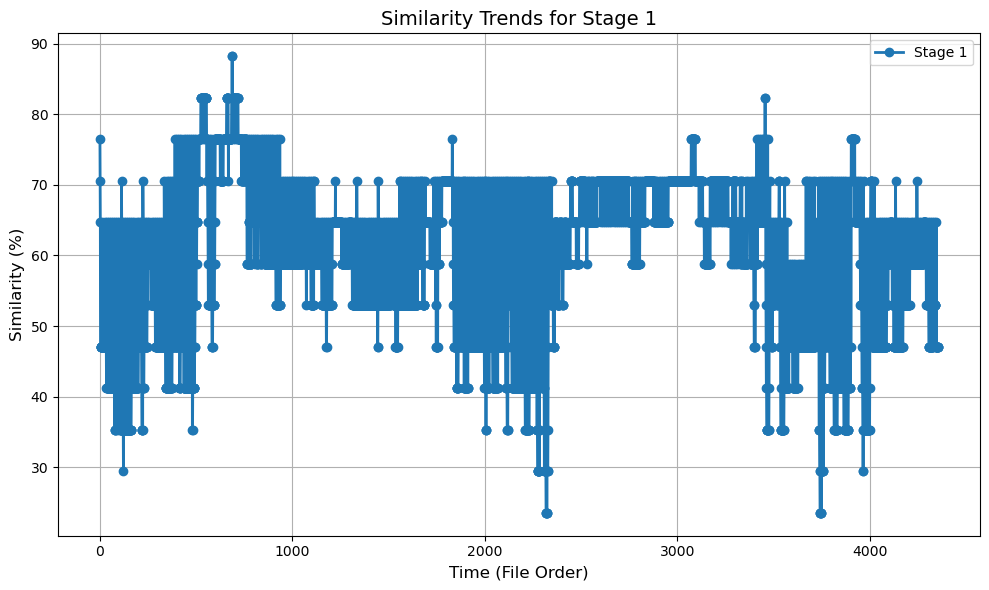


Visualizing similarity trends for stage2...


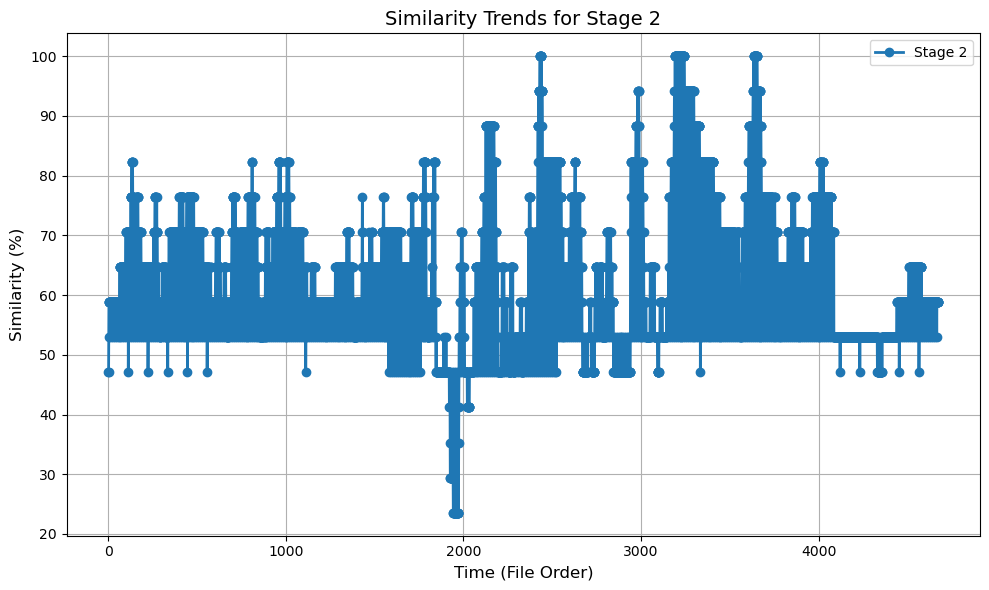


Results saved to 'stage1_results.csv' and 'stage2_results.csv'.

Analyzing user: 124
Found 4288 files in stage1.
Found 5963 files in stage2.

Processing stage1 files...

Processing stage2 files...

Visualizing similarity trends for stage1...


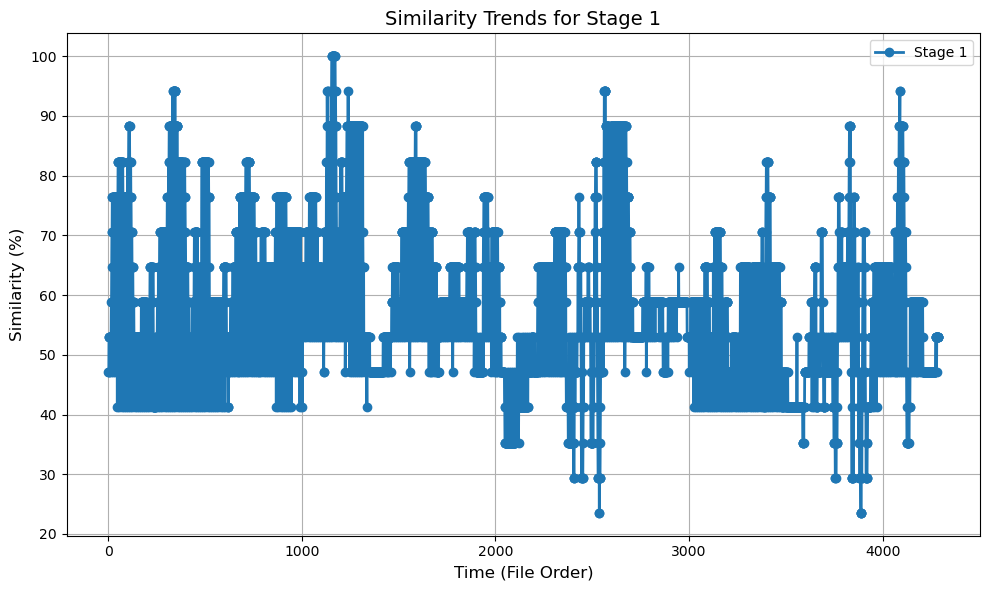


Visualizing similarity trends for stage2...


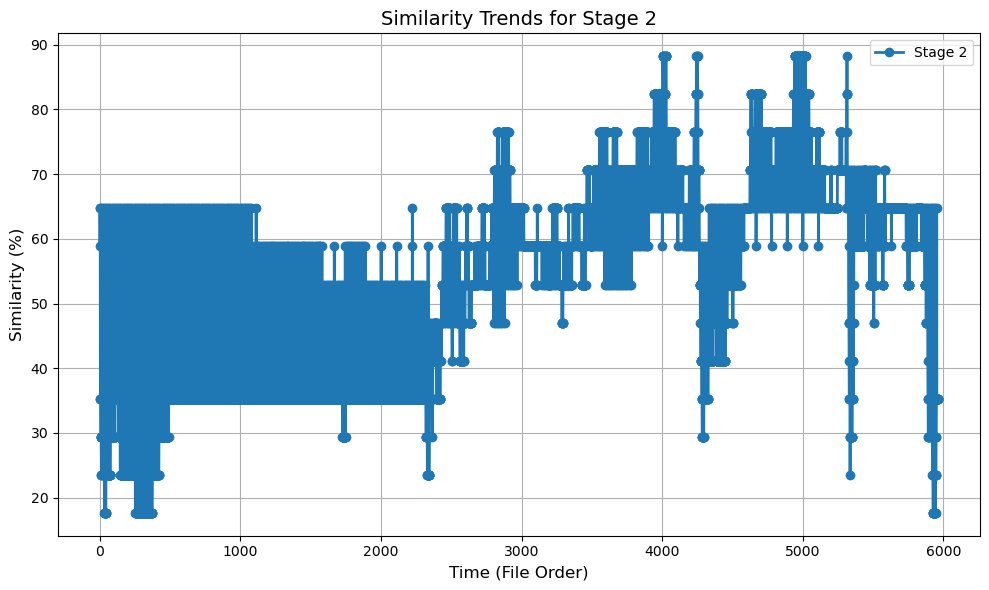


Results saved to 'stage1_results.csv' and 'stage2_results.csv'.

Analyzing user: 196
Found 3592 files in stage1.
Found 1682 files in stage2.

Processing stage1 files...

Processing stage2 files...

Visualizing similarity trends for stage1...


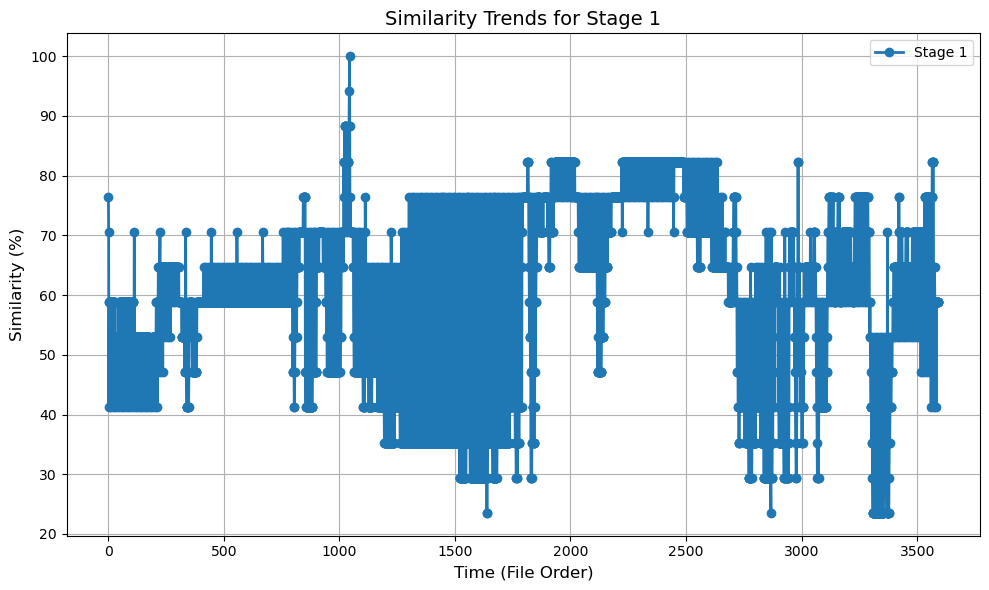


Visualizing similarity trends for stage2...


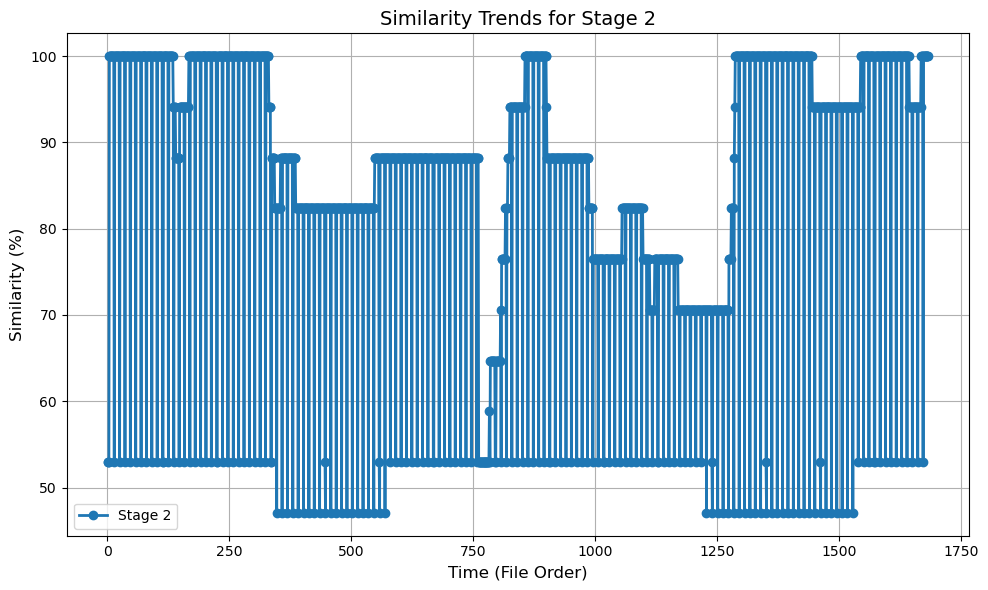


Results saved to 'stage1_results.csv' and 'stage2_results.csv'.


In [21]:
# Home folder path
root_folder = "user_test_oculus3/user_test_oculus3/files"
standard_pose_file = "standard_gesture_female.json"
# Multi-user analysis functions
results = analyze_all_users(root_folder, standard_pose_file, rotation_threshold=15.0)

In [22]:
def save_user_results_to_csv(results, root_folder):
    """
    Save each user's results to individual CSV files in their respective folders.
    """
    for user_id, user_data in results.items():
        # Stage 1 results
        stage1_csv_path = os.path.join(root_folder, user_id, "stage1_results.csv")
        with open(stage1_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["File Index", "Similarity"])
            for idx, similarity in enumerate(user_data["stage1"], start=1):
                writer.writerow([idx, similarity])

        # Stage 2 results
        stage2_csv_path = os.path.join(root_folder, user_id, "stage2_results.csv")
        with open(stage2_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["File Index", "Similarity"])
            for idx, similarity in enumerate(user_data["stage2"], start=1):
                writer.writerow([idx, similarity])

        print(f"Results saved for user {user_id} in {stage1_csv_path} and {stage2_csv_path}")

In [23]:
save_user_results_to_csv(results, root_folder)

Results saved for user 104 in user_test_oculus3/user_test_oculus3/files\104\stage1_results.csv and user_test_oculus3/user_test_oculus3/files\104\stage2_results.csv
Results saved for user 107 in user_test_oculus3/user_test_oculus3/files\107\stage1_results.csv and user_test_oculus3/user_test_oculus3/files\107\stage2_results.csv
Results saved for user 124 in user_test_oculus3/user_test_oculus3/files\124\stage1_results.csv and user_test_oculus3/user_test_oculus3/files\124\stage2_results.csv
Results saved for user 196 in user_test_oculus3/user_test_oculus3/files\196\stage1_results.csv and user_test_oculus3/user_test_oculus3/files\196\stage2_results.csv


In [24]:
def plot_user_results_scatter(results, root_folder):
    """
    Generate and save scatter plots for each user's similarity trends.
    """
    for user_id, user_data in results.items():
        # Plot stage1 scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(
            list(range(1, len(user_data["stage1"]) + 1)),
            user_data["stage1"],
            label=f"Stage 1 - {user_id}",
            c="blue",  # Color of the points
            s=1
        )
        plt.xlabel("Time (File Order)", fontsize=12)
        plt.ylabel("Similarity (%)", fontsize=12)
        plt.title(f"Similarity Trends (Scatter) for {user_id} - Stage 1", fontsize=14)
        plt.legend()
        plt.grid()
        stage1_plot_path = os.path.join(root_folder, user_id, "stage1_similarity_scatter.png")
        plt.savefig(stage1_plot_path)
        plt.close()

        # Plot stage2 scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(
            list(range(1, len(user_data["stage2"]) + 1)),
            user_data["stage2"],
            label=f"Stage 2 - {user_id}",
            c="orange",  # Color of the points
            s=1
        )
        plt.xlabel("Time (File Order)", fontsize=12)
        plt.ylabel("Similarity (%)", fontsize=12)
        plt.title(f"Similarity Trends (Scatter) for {user_id} - Stage 2", fontsize=14)
        plt.legend()
        plt.grid()
        stage2_plot_path = os.path.join(root_folder, user_id, "stage2_similarity_scatter.png")
        plt.savefig(stage2_plot_path)
        plt.close()

        print(f"Scatter plots saved for user {user_id} in {stage1_plot_path} and {stage2_plot_path}")


In [25]:
plot_user_results_scatter(results, root_folder)

Scatter plots saved for user 104 in user_test_oculus3/user_test_oculus3/files\104\stage1_similarity_scatter.png and user_test_oculus3/user_test_oculus3/files\104\stage2_similarity_scatter.png
Scatter plots saved for user 107 in user_test_oculus3/user_test_oculus3/files\107\stage1_similarity_scatter.png and user_test_oculus3/user_test_oculus3/files\107\stage2_similarity_scatter.png
Scatter plots saved for user 124 in user_test_oculus3/user_test_oculus3/files\124\stage1_similarity_scatter.png and user_test_oculus3/user_test_oculus3/files\124\stage2_similarity_scatter.png
Scatter plots saved for user 196 in user_test_oculus3/user_test_oculus3/files\196\stage1_similarity_scatter.png and user_test_oculus3/user_test_oculus3/files\196\stage2_similarity_scatter.png
